### See these links for good workflow information:

https://atmamani.github.io/projects/dl/fastai/fastai-1/

https://blog.paperspace.com/building-a-state-of-the-art-bacterial-classifier-with-paperspace-gradient-and-fast-ai/

### A Face-Mask image classifier.

In this notebook I code an image classifier to detect the wearing and non-wearing of facemasks

### In this notebook I will train a cnn to do image classification.

I will do it from scratch using the online documentation for the various parts of the classifier

### Import modules

In [202]:
import fastai
from fastai.vision import *
from fastai.metrics import error_rate
import torch

In [203]:
# make sure my cuda gpu is accessible
torch.cuda.is_available()

True

In [204]:
torch.backends.cudnn.enabled

True

### Load Data

### Create a data folder in our root

In [12]:
!mkdir data

### Get images for our datasets

Credit for this java script goes to Jeremy Howard at Fastai. I borrowed this cell from Jeremy's Fastai MOOC.

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

In Google Chrome press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> on Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. In Firefox press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> on Windows/Linux or <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

In [50]:
folder = 'face_masks'
file = 'urls_facemasks.csv'

In [43]:
folder = 'no-mask'
file = 'urls_no-mask.csv'

In [162]:
path = Path('data/faces/')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [205]:
path.ls()


[WindowsPath('data/faces/cleaned.csv'),
 WindowsPath('data/faces/export.pkl'),
 WindowsPath('data/faces/face-masks'),
 WindowsPath('data/faces/face_masks'),
 WindowsPath('data/faces/face_no_mask.jpg'),
 WindowsPath('data/faces/foo.jpg'),
 WindowsPath('data/faces/mask1.jpg'),
 WindowsPath('data/faces/models'),
 WindowsPath('data/faces/no-mask'),
 WindowsPath('data/faces/urls_facemasks.csv'),
 WindowsPath('data/faces/urls_no-mask.csv')]

## Download images

### First create my labels

This will create additional folders on the drive named the same as the 'classes' 

In [206]:
classes = ['face-masks','no-mask']

### Now download the images

In [54]:
 download_images(path/file, dest, max_pics=200)

### Verify usable images
Check if the images in path aren't broken, maybe resize them and copy it in dest.

https://docs.fast.ai/vision.data.html#verify_images

In [207]:
path

WindowsPath('data/faces')

In [208]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500, max_workers=4)

face-masks
no-mask


### Visualize a few images

### Prepare the data for training

A good description of tfms: https://www.kaggle.com/init27/introduction-to-image-augmentation-using-fastai

### Create the databunch

Data augmentation

Data augmentation is perhaps the most important regularization technique when training a model for Computer Vision: instead of feeding the model with the same pictures every time, we do small random transformations (a bit of rotation, zoom, translation, etc...) that don't change what's inside the image (to the human eye) but do change its pixel values. Models trained with data augmentation will then generalize better.

https://docs.fast.ai/vision.transform.html

### Databunch info:

https://docs.fast.ai/vision.data.html

class ImageDataBunch
[source]
[test]

    ImageDataBunch(train_dl:DataLoader, valid_dl:DataLoader, fix_dl:DataLoader=None, test_dl:Optional[DataLoader]=None, device:device=None, dl_tfms:Optional[Collection[Callable]]=None, path:PathOrStr='.', collate_fn:Callable='data_collate', no_check:bool=False) :: DataBunch



### Factory methods

If you quickly want to get a ImageDataBunch and train a model, you should process your data to have it in one of the formats the following functions handle.
from_folder
[source]
[test]

    from_folder(path:PathOrStr, train:PathOrStr='train', valid:PathOrStr='valid', test:Union[Path, str, NoneType]=None, valid_pct=None, seed:int=None, classes:Collection[T_co]=None, **kwargs:Any) → ImageDataBunch
    
### get_transforms returns a tuple of two lists of transforms: 

one for the training set and one for the validation set (we don't want to modify the pictures in the validation set, so the second list of transforms is limited to resizing the pictures). This can be passed directly to define a DataBunch object (see below) which is then associated with a model to begin training.


In [209]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224,
                                 num_workers=4).normalize(imagenet_stats)

### Lets' see what the data-object looks like

The training set has 288 photos RGB, and 224 x 224 pixels and my validation set has only 72 images

In [210]:
data

ImageDataBunch;

Train: LabelList (291 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
faces,faces,faces,face_masks,face_masks
Path: data\faces;

Valid: LabelList (72 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
face_masks,no-mask,no-mask,no-mask,face_masks
Path: data\faces;

Test: None

In [211]:
data.classes

['face_masks', 'faces', 'no-mask']

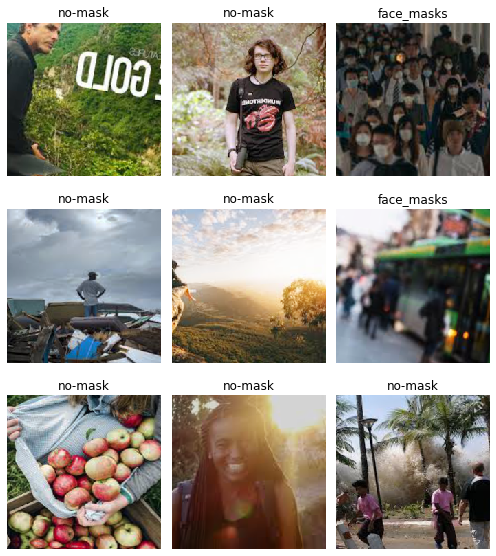

In [212]:
data.show_batch(rows=3, figsize=(7,8))

### Below shows only 2 labels aka 'classes', 288 images in the training set and 72 images in the validation set

In [213]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['face_masks', 'faces', 'no-mask'], 3, 291, 72)

### Train the model

https://docs.fast.ai/vision.learner.html

### First define the learner method-In this example I use the pytorch 'resnext50_32x4d'

I can group metrics in a comma-separated list to get multiple metrics output. I use a pre-trained model to speed 
things up using transfer learning. All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 

https://pytorch.org/docs/stable/torchvision/models.html

In [214]:
import torchvision.models as models

In [215]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)

### See this paper for more info about resnext50
https://arxiv.org/abs/1611.05431

If I want to come back to a model I have re-run my cnn_learner and then I can re-load models I have saved without having to re-create new models.

For example: 

*(learn_resnext50 = cnn_learner(data, models.resnext50_32x4d, metrics=[error_rate, accuracy])

*(learn_resnext50.load('resnext-2')

will load a previously-saved model so I can do more optimizations, etc. or just come back to notebook later.

In [216]:
learn_resnext50 = cnn_learner(data, models.resnext50_32x4d, metrics=[error_rate, accuracy])

In [217]:
learn_resnext50.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.433341,1.354129,0.361111,0.638889,00:28
1,0.992287,1.156896,0.263889,0.736111,00:29
2,0.715349,0.436497,0.111111,0.888889,00:28
3,0.595409,0.343682,0.083333,0.916667,00:30


On epoch 7 you can see I have an error rate of 3.7% with almost 92% accuracy. That is pretty amazing

### Save the trained model

This will save my trained to my hardrive so I don't have to re-train.

In [218]:
learn_resnext50.save('resnext-1')

In [219]:
learn_resnext50.load('resnext-1')

Learner(data=ImageDataBunch;

Train: LabelList (291 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
faces,faces,faces,face_masks,face_masks
Path: data\faces;

Valid: LabelList (72 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
face_masks,no-mask,no-mask,no-mask,face_masks
Path: data\faces;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [220]:
learn_resnext50.unfreeze()

In [25]:
learn_resnext50.load('resnext-2')

Learner(data=ImageDataBunch;

Train: LabelList (288 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
face_masks,face_masks,face_masks,face_masks,face_masks
Path: data\faces;

Valid: LabelList (72 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
no-mask,face_masks,face_masks,face_masks,face_masks
Path: data\faces;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentu

### Validation

Since this is a classification problem, we use confusion matrix for accuracy assessment. We create a ClassificationInterpretation object using the Learner object created earlier

In [221]:
interp = ClassificationInterpretation.from_learner(learn_resnext50)
type(interp)

fastai.train.ClassificationInterpretation

We can plot the top losses using the plot_top_losses() method off the Learner object. This plots the top ‘n’ classes where the classifier has least precision.

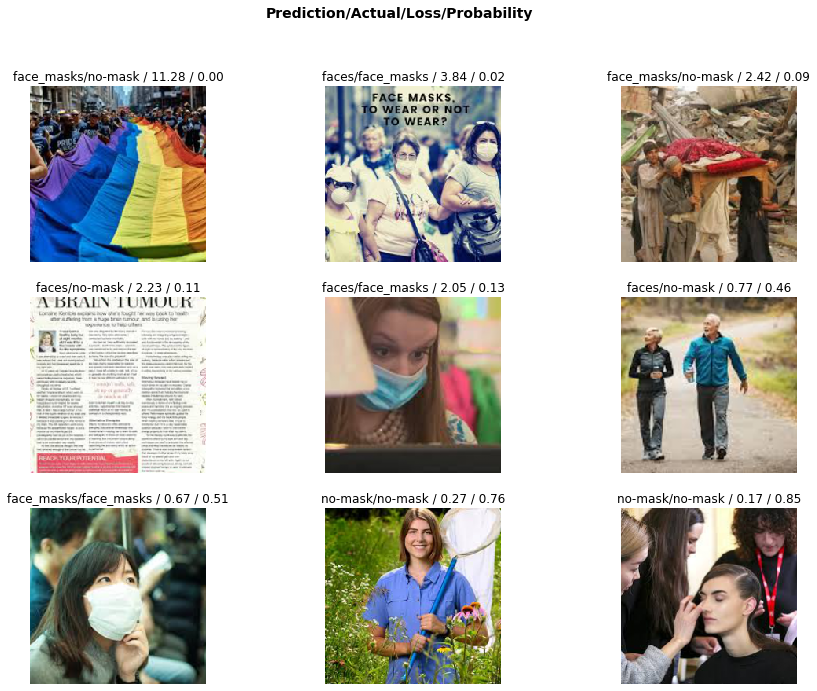

In [222]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

Another option is to plot all misclassifications using a confusion matrix:

In [223]:
#learn_resnext50.load('resnext-3')

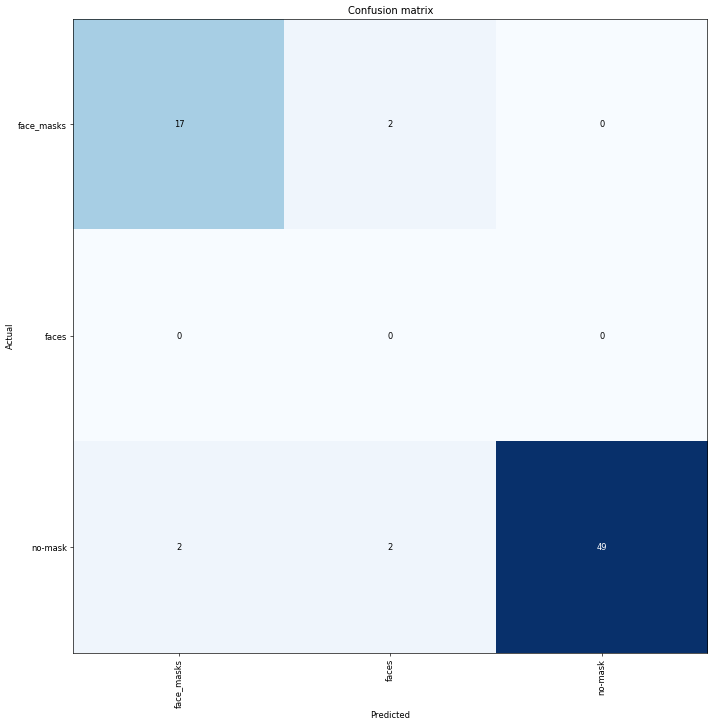

In [224]:

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

If you notice above, a lot of classes have values 1. To view the list of classes most misclassified as a list, use:

### List the classes that the learner got wrong the most

In [225]:
interp.most_confused(min_val=2) # display descending order all values other than diagonal. Ignore 1s though.

[('face_masks', 'faces', 2),
 ('no-mask', 'face_masks', 2),
 ('no-mask', 'faces', 2)]

From the output above it looks like the 'no-masks' images got mis-classified the most

### Model fine-tuning

So far, we took a resnet34 model, added a few layers to the end and trained. This was very fast. However, to improve this furthure, we need to retrain the whole model, meaning, all its layers.

resnet34 has 34 layers, resnet50 has 50 layers. For instance, these are how the layers in resnet look like

    *layer 1 - looks for edges
    *layer 2 - activates for two edges, curves. Thus can detect window, table corners, circles such as clocks
    *layer 3 - for patterns of layer 2 - thus can sense geometric shapes, lines of text or barcode
    *layer 4 - people's faces

    *layer 5 - people faces, eyeball of animaps, tires, faces with masks

    Thus earlier, when we trained on resnet 34, we kept these layers as is and only trained on a few on top of them. To tune the model, we don’t really have to change levels 1,2 which are fundamental. There are not many ways to improve levels 1,2. As levels increase, different levels of semantic complexity are handled.

However, when we make the resnet learn on all layers, it performs worse! To balance, we unfreeze, then load the saved model we had earlier. Then we ask it to run a learning rate finder. The learning rate is pretty important, it says, “how quickly am I updating the parameters in my model”. The general pattern of lr rate is, it improves and then degenerates after some point.

Thus the general pattern advocated is to use the lr finder to find the shape of learning rate. Then unfreeze and call fit method with appropriate learning rate window. This trains the lower layers at a rate and higher abstraction layers are a different rate.

### let's find the learning rate and plot it out so I can try to tune the learner again to get a more accurate result.

The training loss should be going down on each epoch otherwise start using some parameters

So how do you find a good learning rate? see this:

https://forums.fast.ai/t/cyclical-learning-rate-fastai-implementation-clarifications/48311/4

https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

In [226]:
learn_resnext50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


From the output above the learning rate steadily drops per each epoch. This is what we want to see.

### Now plot the learning rate to visualize the result in order to re-train with new parameters

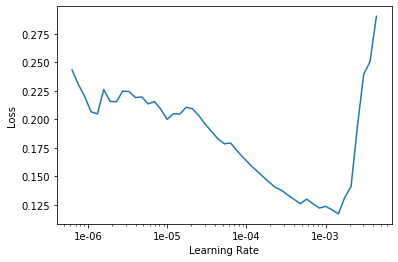

In [227]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn_resnext50.recorder.plot()

### from the above plot I will try to find the best 'fit' for re-learning to improve accuracy

In [229]:
learn_resnext50.fit_one_cycle(2, max_lr=slice(3e-64,3e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.324714,0.438110,0.111111,0.888889,00:30
1,0.343791,0.311456,0.055556,0.944444,00:30


In [230]:
learn_resnext50.save('resnext-3')

### This part is optional as a comparison between resnext50 resnet34

### Let's re-train, this time using 'resnet34' and compare the results between the two different pre-trained models

In [39]:
learn_resnet34 = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [173]:
learn_resnet34.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.246369,1.139250,0.347222,0.652778,00:48
1,0.761605,0.420598,0.097222,0.902778,00:31
2,0.587437,0.254703,0.055556,0.944444,00:38
3,0.499837,0.221391,0.055556,0.944444,00:49


Comparing the results from both models I can see that the "resnext50_32x4d" provides an accuracy of 97% versus "resnet34" which has an accuracy of 94%. "resnext50_32x4d" also has a lower validation and lower error rate. I think that using "resnext50_32x4d" is probably the better training model to use.

### Save the trained model
This will save my trained to my hardrive so I don't have to re-train.

In [174]:
learn_resnet34.save('resnet34-1')

### Now unfreeze the model. See this link for info:
Here we do a backward through the neural-net to do more learning but we do want to change the weights we have already established in order to improve learning.

https://stats.stackexchange.com/questions/393168/what-does-it-mean-to-freeze-or-unfreeze-a-model

In [231]:
learn_resnext50.load('resnext-3')

Learner(data=ImageDataBunch;

Train: LabelList (291 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
faces,faces,faces,face_masks,face_masks
Path: data\faces;

Valid: LabelList (72 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
face_masks,no-mask,no-mask,no-mask,face_masks
Path: data\faces;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [84]:
#learn_resnet34.load('resnet34-1')

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [79]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the `ds_type` param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [83]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [233]:
import torchvision.models as models
resnext50_32x4d = models.resnext50_32x4d()

In [234]:
learn_cln = cnn_learner(db, models.resnext50_32x4d, metrics=error_rate)

learn_cln.load('resnext-3');

RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 1.8.weight: copying a param with shape torch.Size([3, 512]) from checkpoint, the shape in current model is torch.Size([2, 512]).
	size mismatch for 1.8.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).

In [89]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [90]:
# no need to do this import
import ipywidgets as widgets

In [91]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)

'No images to show :)'

If the code above does not show any GUI(contains images and buttons) rendered by widgets but only text output, that may caused by the configuration problem of ipywidgets. Try the solution in this [link](https://github.com/fastai/fastai/issues/1539#issuecomment-505999861) to solve it.

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [92]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [93]:
ImageCleaner(ds, idxs, path, duplicates=True)

'No images to show :). 250 pairs were skipped since at least one of the images was deleted by the user.'

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

Here I am actually able to grab any random image run it through my trained model and am getting so far, 100% accuracy on predictions

In [235]:
learn_resnext50.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [236]:
defaults.device = torch.device('cpu')

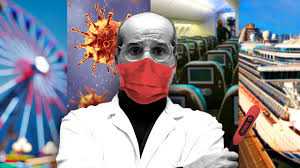

In [261]:
img = open_image(path/'fum4.jpg')
img

We create our `learn_resnext50` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [262]:
learn = load_learner(path)

In [263]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class)

face_masks


### Final Comments and Review

This wraps-up this image classifier. Let's review what I did in this notebook:

* Download the images from google images using a java script to save the urls for later download of the actual images.
* Create my lables (classes).
* I obtained the data (images) for my classifier which consisted of people wearing fasks and note wearing face masks.
* Load the data and create folders as required.
* Verify usable images.
* Create an image databunch (tensor) 
* Define a learner method and train the model.
* Save the trained model. Note that I can do multiple models and save as many as I want to.
* Validate the model using 'ClassificationInterpretation' and show the top losses.
* Plot a confusion matrix showing classification errors.
* Fine-tune the ,model using '.lr_find'.
* Plot the learning rates and fine-tune again. Remember to save the model with the best results.
* Clean up the model by removing duplicates and outlier images.
* ...And finally put the model into production using completely new images from outside of my dataset to verify the model's ability top make accurate predictions.